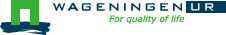



# Simulating grassland productivity with LINGRA

This Jupyter notebook will demonstrate how to run the LINGRA model in order to simulate grassland productivity under potential and water-limited conditions. To demonstrate the model we will simulate grassland productivity for 1983 in Wageningen for potential and water-limited conditions.

The LINGRA model was developed specifically for grasslands and includes some of the dynamics that are specifically for rye grass such as the continuous development of tillers from which new leaves will form and the existence of a reserve pool of assimilates that can be used for quick regrowth after defoliation due to harvesting or grazing. For more information on LINGRA see [this paper](https://dx.doi.org/10.1016/S1161-0301(98)00027-6).

Allard de Wit, September 2021

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE >= 5.5.0 and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `matplotlib` module for generating charts
 


# 1. Importing the relevant modules


In [1]:
%matplotlib inline
import sys, os
import datetime as dt

import yaml
import requests
import pandas as pd
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import LINGRA_PP, LINGRA_WLP_FD
from pcse.fileinput import YAMLCropDataProvider, CABOWeatherDataProvider
from pcse.base import ParameterProvider
from pcse.util import WOFOST72SiteDataProvider
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.12 | packaged by conda-forge | (default, Sep 16 2021, 01:40:49) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.5.3


# 2 Setting up LINGRA

## 2.1 Defining agromanagement
The agromanagement definition for running LINGRA is quite similar to running WOFOST but because of the particular properties of grassland there are some differences:
- the crop name is always 'rye_grass'
- there are currently only two varieties 'Northern_RyeGrass' and 'Southern_RyeGrass'
- the `crop_start_type` has no impact so `sowing` is used by default.
- The `maximum duration` does not play a role here, so it is set to an arbitrary high number.
- a mowing schedule must be defined. The mowing schedule defines the mowing dates and the amount of biomass that remains on the field. The amount of biomass remaining can also be estimated as the remaining LAI divided by the specific leaf area (SLA).

Currently, the model does not yet support grazing.

For the example, we will run a grassland simulation for Wageningen in 1983 with the following agromanagement definition.  

In [2]:
year = 1983
mowing_doys = [135., 165., 200., 240., 280.]
mowing = [dt.date(year,1,1) + dt.timedelta(days=(doy-1)) for doy in mowing_doys]
rbiomass = 320.0
agro_yaml = f"""
        - {year}-01-01:
            CropCalendar:
                crop_name: rye_grass
                variety_name: Northern_RyeGrass
                crop_start_date: {year}-01-01
                crop_start_type: sowing
                crop_end_date: {year}-12-31
                crop_end_type: harvest
                max_duration: 1000
            TimedEvents:
            -   event_signal: mowing
                name:  Schedule a grass mowing event
                comment: Remaining biomass in kg/ha
                events_table:
                - {mowing[0]}: {{biomass_remaining: {rbiomass}}}
                - {mowing[1]}: {{biomass_remaining: {rbiomass}}}
                - {mowing[2]}: {{biomass_remaining: {rbiomass}}}
                - {mowing[3]}: {{biomass_remaining: {rbiomass}}}
                - {mowing[4]}: {{biomass_remaining: {rbiomass}}}
            StateEvents: null
        - {year}-12-31:
        """
agro = yaml.safe_load(agro_yaml)
print(agro_yaml)


        - 1983-01-01:
            CropCalendar:
                crop_name: rye_grass
                variety_name: Northern_RyeGrass
                crop_start_date: 1983-01-01
                crop_start_type: sowing
                crop_end_date: 1983-12-31
                crop_end_type: harvest
                max_duration: 1000
            TimedEvents:
            -   event_signal: mowing
                name:  Schedule a grass mowing event
                comment: Remaining biomass in kg/ha
                events_table:
                - 1983-05-15: {biomass_remaining: 320.0}
                - 1983-06-14: {biomass_remaining: 320.0}
                - 1983-07-19: {biomass_remaining: 320.0}
                - 1983-08-28: {biomass_remaining: 320.0}
                - 1983-10-07: {biomass_remaining: 320.0}
            StateEvents: null
        - 1983-12-31:
        


## 2.2 model parameters
Crop parameters for rye grass can be obtained from a repository on github. 

For the site parameters, we can use the WOFOST site data provider since LINGRA reuses some components of WOFOST. Only the initial soil temperature has to be added. 

Finally, soil parameters are not exactly known for this site so we use a 'medium fine' soil profile.

In [3]:
YAMLCropDataProvider.crop_types = ["rye_grass"]
repo = "https://raw.githubusercontent.com/ajwdewit/LINGRA_crop_parameters/master/"
cropd = YAMLCropDataProvider(repository=repo, force_reload=True)

# Soil data from soil type "EC3-medium-fine" as in CGMS-LINGRA doc (Bouman et al 1996).
soild = {"SMFCF": 0.30,
         "SMW": 0.104,
         "SM0": 0.41,
         "CRAIRC": 0.06,
         "RDMSOL": 40,
         "KSUB":1.47,
         "SOPE":1.47
}

# Site parameters
sited = WOFOST72SiteDataProvider(WAV=10)
sited["TemperatureSoilinit"] = 5.0

params = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

# 2.3 Weather data
LINGRA uses the same weather inputs as WOFOST so we will read weather inputs from a CABO weather file.

In [4]:
from pathlib import Path
meteo_dir  = Path.cwd() / "data" / "meteo"
wdp = CABOWeatherDataProvider(fpath=meteo_dir, fname="NL1")
print(wdp)

Weather data provided by: CABOWeatherDataProvider
--------Description---------
----Site characteristics----
Elevation:   10.0
Latitude:  51.990
Longitude:  5.630
Data available for 1983-01-01 - 1984-12-31
Number of missing days: 0



# 3. Running LINGRA for Potential Production


In [5]:
lingra = LINGRA_PP(params, wdp, agro)
lingra.run_till_terminate()
df_PP = pd.DataFrame(lingra.get_output()).set_index("day")
df_PP.head()

,LAI,TillerNumber,WeightLVgreen,WeightRE,WeightRT,SLAINT,WeightHARV,WeightABG,RFTRA,LeafLength
day,,,,,,,,,,
1983-01-01,0.100000,7000.000000,40.000000,200.000000,4.000000,0.0025,0.0,40.000000,1.0,0.000000
1983-01-02,0.099005,7042.462000,39.601993,201.080384,4.000000,0.0025,0.0,39.601993,1.0,0.000000
1983-01-03,0.143581,7075.100259,57.432505,180.136946,7.601260,0.0025,0.0,57.432505,1.0,0.215651
1983-01-04,0.246538,7105.131855,98.615170,130.525617,15.852076,0.0025,0.0,98.615170,1.0,0.707448
1983-01-05,0.456755,7136.552499,182.702129,29.569483,32.661959,0.0025,0.0,182.702129,1.0,1.705179


## 3.1 Interpreting output
The table above and figure below demonstrate the different variables that are provided by the LINGRA model. It includes the biomass in the different pools (leaves - *WeightLVgreen*, roots - *WeightRT*, reserves - *WeightRE*) as well as the summary variables providing insight in the total harvested material (*WeightHARV*) and total biomass (*WeightABG*). The *WeightHARV* typically increase with every harvest, while at the same time leaf area index (*LAI*) and leaf length (*LeafLength*) drop. 

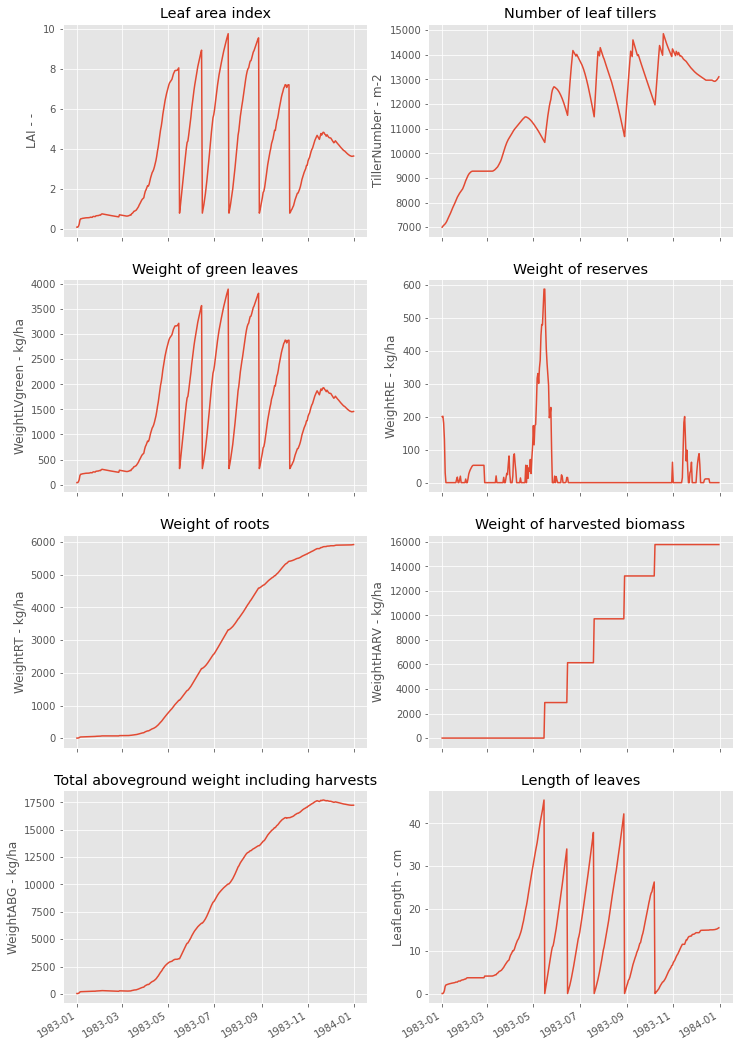

In [6]:
LINGRA_variables = [
    ("LAI", "Leaf area index", "-"),
    ("TillerNumber", "Number of leaf tillers", "m-2"),
    ("WeightLVgreen", "Weight of green leaves", "kg/ha"),
    ("WeightRE", "Weight of reserves", "kg/ha"),
    ("WeightRT", "Weight of roots", "kg/ha"),
    ("WeightHARV", "Weight of harvested biomass", "kg/ha"),
    ("WeightABG", "Total aboveground weight including harvests", "kg/ha"),
    ("LeafLength", "Length of leaves", "cm"),
]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,20))
for (varname, description, unit), ax in zip(LINGRA_variables, axes.flatten()):
    ax.plot(df_PP.index, df_PP[varname])
    ax.set_title(description)
    ax.set_ylabel(f"{varname} - {unit}")
fig.autofmt_xdate()


# 4. Running LINGRA for water-limited conditions

In [7]:
lingra = LINGRA_WLP_FD(params, wdp, agro)
lingra.run_till_terminate()
df_WLP = pd.DataFrame(lingra.get_output()).set_index("day")
df_WLP.head()

,LAI,TillerNumber,WeightLVgreen,WeightRE,WeightRT,SLAINT,WeightHARV,WeightABG,RFTRA,LeafLength,SM,TRA,TRAMX,EVS
day,,,,,,,,,,,,,,
1983-01-01,0.100000,7000.000000,40.000000,200.000000,4.000000,0.0025,0.0,40.000000,1.0,0.000000,0.400000,0.002228,0.002228,0.000000
1983-01-02,0.099005,7042.462000,39.601993,201.080384,4.000000,0.0025,0.0,39.601993,1.0,0.000000,0.327456,0.001134,0.001134,0.000000
1983-01-03,0.143581,7075.100259,57.432505,180.136946,7.601260,0.0025,0.0,57.432505,1.0,0.215651,0.308871,0.000736,0.000736,0.000000
1983-01-04,0.246538,7105.131855,98.615170,130.525617,15.852076,0.0025,0.0,98.615170,1.0,0.707448,0.400294,0.018676,0.018676,0.146351
1983-01-05,0.456755,7136.552499,182.702129,29.569483,32.661959,0.0025,0.0,182.702129,1.0,1.705179,0.350000,0.002205,0.002205,0.001322


The LINGRA model for water-limited conditions has some additional variables available such as the crop transpiration (*TRA*) and the water stress reduction factor (*RFTRA*). The plots below demonstrate that there was a period of severe water stress during july-august 1983 causing a strong reduction in the growth of rye grass in Wageningen.

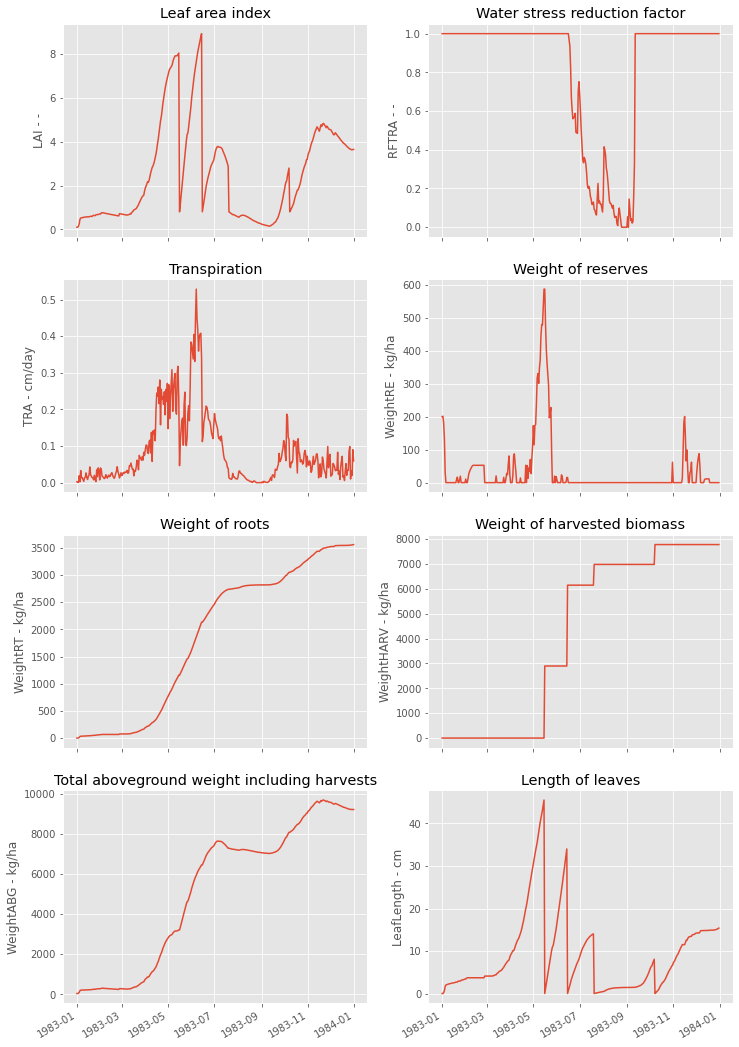

In [8]:
LINGRA_variables = [
    ("LAI", "Leaf area index", "-"),
    ("RFTRA", "Water stress reduction factor", "-"),
    ("TRA", "Transpiration", "cm/day"),
    ("WeightRE", "Weight of reserves", "kg/ha"),
    ("WeightRT", "Weight of roots", "kg/ha"),
    ("WeightHARV", "Weight of harvested biomass", "kg/ha"),
    ("WeightABG", "Total aboveground weight including harvests", "kg/ha"),
    ("LeafLength", "Length of leaves", "cm"),
]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,20))
for (varname, description, unit), ax in zip(LINGRA_variables, axes.flatten()):
    ax.plot(df_WLP.index, df_WLP[varname])
    ax.set_title(description)
    ax.set_ylabel(f"{varname} - {unit}")
fig.autofmt_xdate()

# Combining potential and water-limited product
When combining the simulated total biomass in one chart, the impact of water stress is clearly visible.

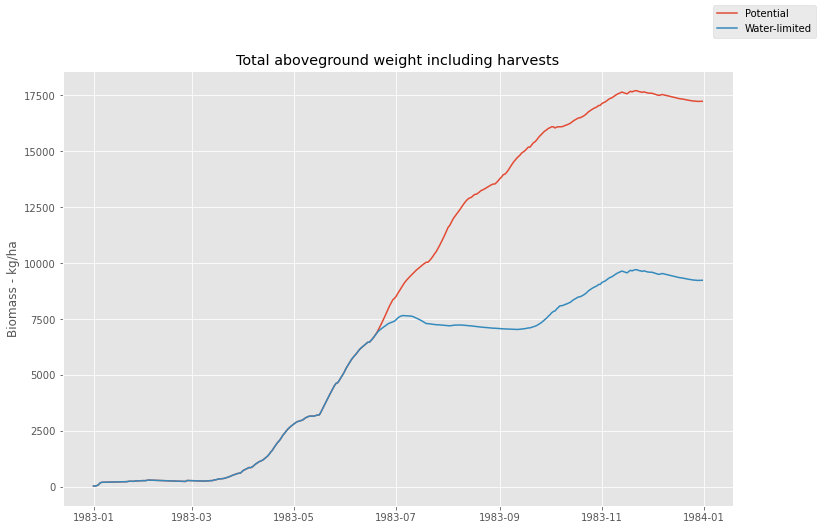

In [9]:
fig, axes = plt.subplots(figsize=(12,8))
axes.plot(df_PP.index, df_PP.WeightABG, label="Potential")
axes.plot(df_WLP.index, df_WLP.WeightABG, label="Water-limited")
axes.set_ylabel("Biomass - kg/ha")
axes.set_title("Total aboveground weight including harvests")
fig.legend()